In [1]:
!pip install gymnasium
!pip install gymnasium[classic-control]

Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
from torch import nn
import torch.nn.functional as F

import import_ipynb
from plastic_nn import plastic_nn
from plastic_nn import input_layer
from plastic_nn import layer

importing Jupyter notebook from plastic_nn.ipynb


In [2]:

# Define memory for Experience Replay
class ReplayMemory():
    def __init__(self, maxlen):
        self.memory = deque([], maxlen=maxlen)

    def append(self, transition):
        self.memory.append(transition)

    def sample(self, sample_size):
        return random.sample(self.memory, sample_size)

    def __len__(self):
        return len(self.memory)




class MountainCarDQL():
    # Hyperparameters (adjustable)
    
    discount_factor_g = 0.9         # discount rate (gamma)
    network_sync_rate = 50000          # number of steps the agent takes before syncing the policy and target network
    replay_memory_size = 100000       # size of replay memory
    mini_batch_size = 32            # size of the training data set sampled from the replay memory

    num_divisions = 20

    
    def plot_progress(self, rewards_per_episode, epsilon_history):
        plt.figure(1)
        plt.subplot(121) 
        plt.plot(rewards_per_episode)
        plt.subplot(122) # plot on a 1 row x 2 col grid, at cell 2
        plt.plot(epsilon_history)
        plt.savefig('mountaincar_dql.png')

    

    def train(self, policy_dqn, target_dqn, episodes, render=False):
        # Create FrozenLake instance
        env = gym.make('MountainCar-v0', render_mode='human' if render else None)
        num_states = env.observation_space.shape[0] # expecting 2: position & velocity
        num_actions = env.action_space.n

        # Divide position and velocity into segments
        self.pos_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], self.num_divisions)    # Between -1.2 and 0.6
        self.vel_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], self.num_divisions)    # Between -0.07 and 0.07

        epsilon = 1 # 1 = 100% random actions
        memory = ReplayMemory(self.replay_memory_size)

        rewards_per_episode = []
        epsilon_history = []

        # Track number of steps taken. Used for syncing policy => target network.
        step_count = 0
        goal_reached = False
        best_rewards = -800

        for i in range(episodes):
            state = env.reset()[0]  # Initialize to state 0
            terminated = False      # True when agent falls in hole or reached goal
            truncated = False
            rewards = 0

            # Agent navigates map until it falls into hole/reaches goal (terminated), or has taken 200 actions (truncated).
            while(not terminated and rewards > -1000):
                if random.random() < epsilon:
                    action = env.action_space.sample() # actions: 0=left,1=idle,2=right
                else:
                    res = policy_dqn.forward(self.state_to_dqn_input(state))
                    #print(res)
                    action = res.argmax().item()

                new_state,reward,terminated,truncated,_ = env.step(action)
                rewards += reward
                memory.append((state, action, new_state, reward, terminated))
                state = new_state
                step_count+=1


            rewards_per_episode.append(rewards)
            #epsilon_history.append(epsilon)
            
            if(terminated):
                goal_reached = True

            # Graph training progress
            if(i!=0 and i%1000==0):
                print(f'Episode {i} Epsilon {epsilon}')
                policy_dqn.save(f'mc_policy_{i}'.format(i))
                self.plot_progress(rewards_per_episode, epsilon_history)

            if rewards>best_rewards:
                best_rewards = rewards
                print(f'Best rewards so far: {best_rewards}')
                policy_dqn.save(f'mc_policy_{i}'.format(i))
                

            # Check if enough experience has been collected
            if len(memory)>self.mini_batch_size and goal_reached:
                
                #print(f'OPTIMIZE Episode {i} Epsilon {epsilon} rewards {rewards}') # print(rewards)
                
                mini_batch = memory.sample(self.mini_batch_size) #len(memory))#
                self.optimize(mini_batch, policy_dqn, target_dqn)

                # Decay epsilon
                epsilon = max(epsilon*0.9999, 0.05)#epsilon = max(epsilon - 1/episodes, 0)
                epsilon_history.append(epsilon)

                # Copy policy network to target network after a certain number of steps
                if step_count > self.network_sync_rate:
                    target_dqn = policy_dqn.deep_copy()
                    step_count = 0
                    #print('UPDATE')
                   
                
                
        env.close()



    
    def optimize(self, mini_batch, policy_dqn, target_dqn):
        current_q_list = []
        target_q_list = []

        
        for state, action, new_state, reward, terminated in mini_batch:

            if terminated:
                target = reward
            else:
                target = reward + self.discount_factor_g * target_dqn.forward(self.state_to_dqn_input(new_state)).max()


            # Get the target set of Q values
            target_q = target_dqn.forward(self.state_to_dqn_input(state))
            
            # Get the current set of Q values
            current_q = policy_dqn.forward(self.state_to_dqn_input(state))
            current_q_list.append(current_q)
            
            # Adjust the specific action to the target that was just calculated
            target_q[action] = target
            target_q_list.append(target_q)

    
            #BACKPOP AND UPDATE
            policy_dqn.backprop(target_q)
            policy_dqn.update_w()


        
        # Compute loss for the whole minibatch ??
    
        #loss = self.loss_fn(torch.stack(current_q_list), torch.stack(target_q_list))

        # Optimize the model
        #self.optimizer.zero_grad()
        #loss.backward()
        #self.optimizer.step()


    def state_to_dqn_input(self, state):
        state_p = np.digitize(state[0], self.pos_space)
        state_v = np.digitize(state[1], self.vel_space)

        return [state_p, state_v]

    # Run the environment with the learned policy
    def test(self, policy_dqn, episodes):
        # Create FrozenLake instance
        env = gym.make('MountainCar-v0', render_mode='human')
        num_states = env.observation_space.shape[0]
        num_actions = env.action_space.n

        self.pos_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], self.num_divisions)    # Between -1.2 and 0.6
        self.vel_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], self.num_divisions)    # Between -0.07 and 0.07

        for i in range(episodes):
            state = env.reset()[0]  # Initialize to state 0
            terminated = False      # True when agent falls in hole or reached goal
            truncated = False       # True when agent takes more than 200 actions

            # Agent navigates map until it falls into a hole (terminated), reaches goal (terminated), or has taken 200 actions (truncated).
            while(not terminated and not truncated):
                dscr = self.state_to_dqn_input(state)
                res = policy_dqn.forward_print(dscr)
                print(res)
                action = res.argmax().item()

                # Execute action
                state,reward,terminated,truncated,_ = env.step(action)
                #terminated = True

        env.close()


In [3]:
learning_rate_a = 0.0001
in_states = 2
h1_nodes = 10
h2_nodes = 10
out_actions = 3

layers_net = [input_layer(in_states), 
layer(lr = learning_rate_a, prev_size = in_states, my_size=h1_nodes, activation_type="ReLU"), 
#layer(lr = learning_rate_a, prev_size = h1_nodes, my_size=h2_nodes, activation_type="ReLU"), 
layer(lr = learning_rate_a, prev_size = h2_nodes, my_size=out_actions, activation_type='Linear')]

policy_dqn = plastic_nn()
policy_dqn.append(layers_net)

target_dqn = plastic_nn()
target_dqn = policy_dqn.deep_copy()
  

0
added LAYERS succesfully


In [4]:
mountaincar = MountainCarDQL()

Episode 1000 Epsilon 1
Episode 2000 Epsilon 1
Episode 3000 Epsilon 1
Episode 4000 Epsilon 1
Best rewards so far: -521.0
Episode 5000 Epsilon 0.9200712509273935
Best rewards so far: -474.0
Episode 6000 Epsilon 0.8325107322566739
Best rewards so far: -450.0
Best rewards so far: -360.0
Episode 7000 Epsilon 0.753283094786358
Episode 8000 Epsilon 0.681595322324285
Best rewards so far: -309.0
Episode 9000 Epsilon 0.6167298677346581
Best rewards so far: -308.0
Episode 10000 Epsilon 0.558037470766336
Best rewards so far: -292.0
Episode 11000 Epsilon 0.5049306593876023
Best rewards so far: -281.0
Episode 12000 Epsilon 0.45687786958011406
Episode 13000 Epsilon 0.413398124735044
Episode 14000 Epsilon 0.3740562213956902
Episode 15000 Epsilon 0.3384583731590423
Episode 16000 Epsilon 0.3062482691346174
Episode 17000 Epsilon 0.2771035075083745
Episode 18000 Epsilon 0.25073236851402725
Episode 19000 Epsilon 0.2268708945113375


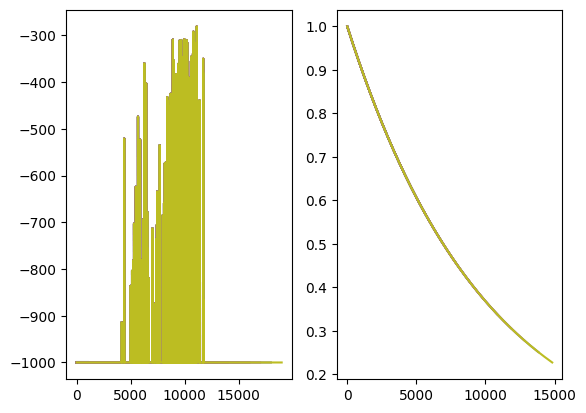

In [5]:
mountaincar.train(policy_dqn, target_dqn, 20000, False)

In [9]:
policy_dqn.save()

In [17]:
policy_dqn.load('mc_policy_1000')

0
added LAYERS succesfully


In [7]:

mountaincar.test(policy_dqn, 1)

in:  [9, 10]
0   [9, 10]
1   [ 0.          0.          0.          0.          0.         12.67889969
  0.          0.          0.          0.        ]
2   [-9.72663833 -9.87330703 -9.96011319]
[-9.72663833 -9.87330703 -9.96011319]
in:  [9, 10]
0   [9, 10]
1   [ 0.          0.          0.          0.          0.         12.67889969
  0.          0.          0.          0.        ]
2   [-9.72663833 -9.87330703 -9.96011319]
[-9.72663833 -9.87330703 -9.96011319]
in:  [9, 10]
0   [9, 10]
1   [ 0.          0.          0.          0.          0.         12.67889969
  0.          0.          0.          0.        ]
2   [-9.72663833 -9.87330703 -9.96011319]
[-9.72663833 -9.87330703 -9.96011319]
in:  [9, 9]
0   [9, 9]
1   [ 0.          0.          0.          0.          0.         11.58340765
  0.          0.          0.          0.        ]
2   [-8.89505996 -8.99306202 -9.08390314]
[-8.89505996 -8.99306202 -9.08390314]
in:  [8, 9]
0   [8, 9]
1   [ 0.         0.         0.         0.         0

In [8]:
policy_dqn.print_info()

NAME:  noname  ( 3 )
# 0
IN LAYER
size:  2

# 1
my size:  10
w:  [[ 0.02335766 -0.41241951 -0.20892924 -0.15650369 -0.15615496  0.10236884
  -0.51546325 -0.01505375 -0.12599114 -0.20480523]
 [-0.20332217  0.0276086  -0.00797993  0.01207372 -0.07290095  1.09549204
   0.02816541 -0.05538183 -0.04535808 -0.07648399]] 

b:  [ 4.96555639e-01  1.86680808e-01  2.48757693e-01 -6.60883606e-04
  6.23904009e-01  8.02659668e-01  2.64341889e-01  2.08869495e-01
  6.65619074e-01  8.83735287e-01] 


# 2
my size:  3
w:  [[ 0.41127384  0.20461111  0.09365556]
 [ 0.19309516  0.57001083  0.10527595]
 [ 0.19781319  0.49741266  0.64442314]
 [ 0.35061025  0.47330242  0.35486213]
 [ 0.40538689  0.46297     0.81211129]
 [-0.75909121 -0.80351566 -0.79983242]
 [ 0.59825856  0.23774724  0.49405129]
 [ 0.65186417  0.34384017  0.53604527]
 [-0.08506953 -0.08190245  0.35279913]
 [ 0.49630298  0.02977923  0.06812444]] 

b:  [-0.10219709  0.31438739  0.18088183] 


